# Comparing molecules among Datasets:
#### CSAR - DUD - DEKOIS2.0 - Cocristalized Molecules

In [20]:
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='talk', font_scale=0.9)

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './rdKit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)
print(lig_datasets.keys())

dict_keys(['COCRYS', 'CSAR', 'DUD', 'DEKOIS'])


### Molecular Weight and Number of Heavy atoms

In [35]:
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

# Get the molecular weight and # of heavy atoms for each ligand
for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']]
    


In [4]:
from helper_functions_2 import violin_plot_helper

### Molecular Weight


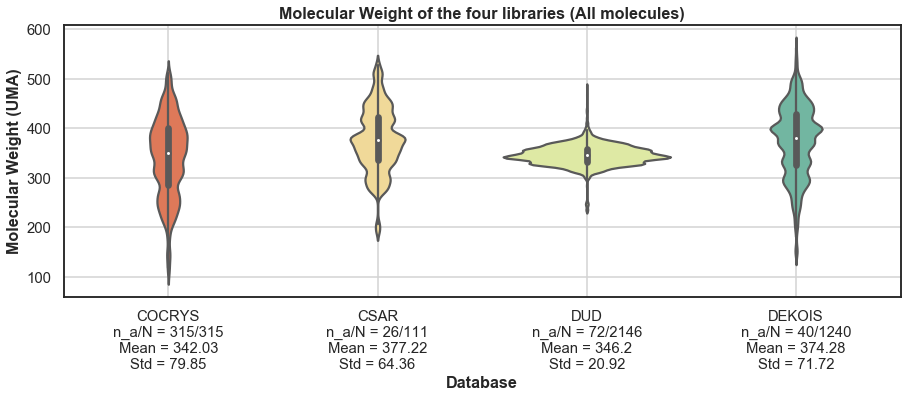

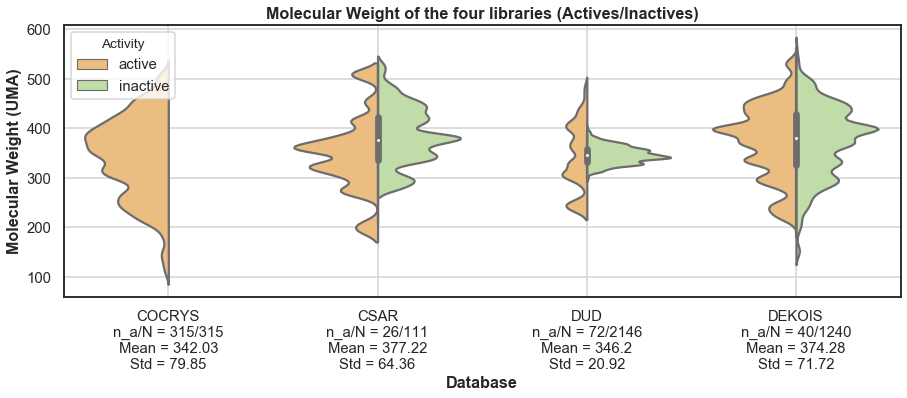

In [43]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Weight of the four libraries (All molecules)',
                   xlabel= 'Database', ylabel = 'Molecular Weight (UMA)', split=False)
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Weight of the four libraries (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Molecular Weight (UMA)', split=True)

### Number of Heavy Atoms

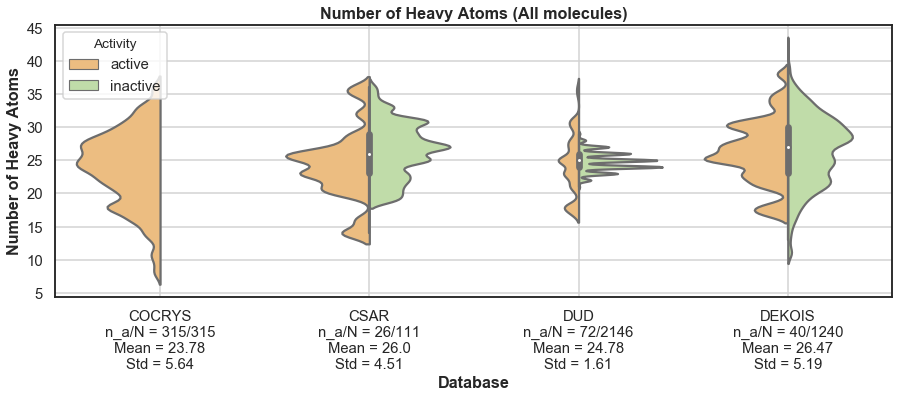

In [42]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split=True)

### Number of Rings

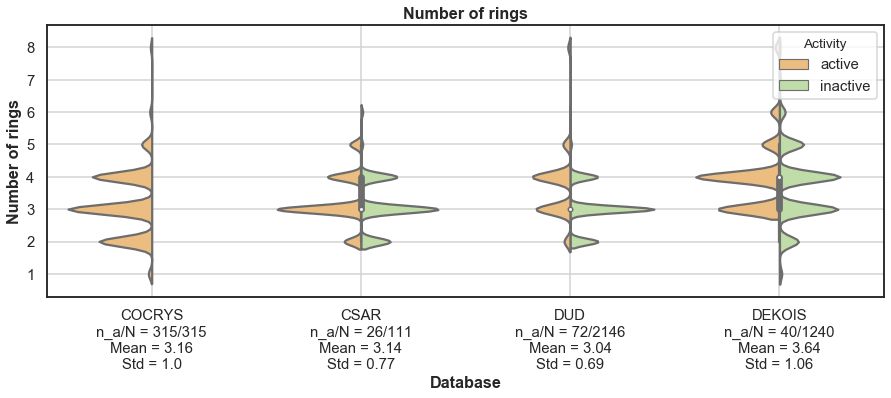

In [39]:
violin_plot_helper('num_rings', lig_datasets,
                   title = 'Number of rings (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Number of rings', split=True)

### Number of Rotatable Bonds

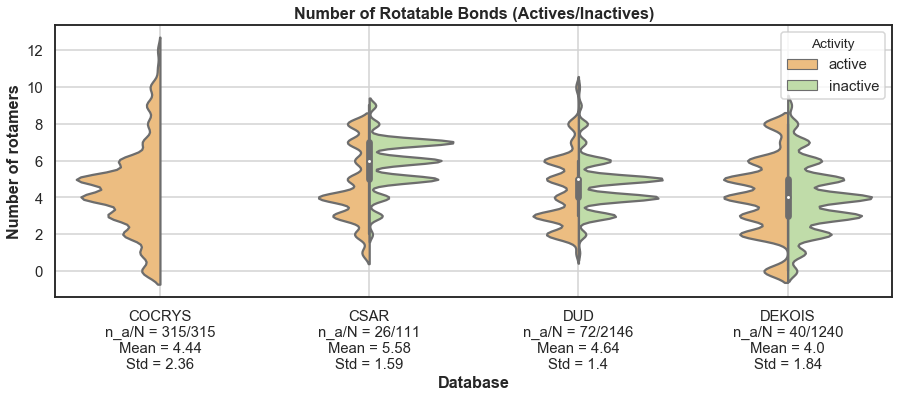

In [44]:
violin_plot_helper('num_rot', lig_datasets,
                   title = 'Number of Rotatable Bonds (Actives/Inactives)',
                   xlabel= 'Database', ylabel = 'Number of rotamers', split=True)

## Fingerprints Computation
[Comparing Fingerprints](http://rdkit.blogspot.com/2013/10/comparing-fingerprints-to-each-other.html)

### MACCS keys
- **MACCS key** is a binary fingerprint (**166-bit-long**).
- Each bit position represents the presence (1) or absence (0) of a pre-defined structural feature.
- The feature definitions for the MACCS keys are available [here](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py).
- Usual metric to compare these fp is Tanimoto


In [48]:
from rdkit.Chem import MACCSkeys

for dataset in lig_datasets.values():
    # MACCS Keys Fingetprints
    dataset['fps_maccs'] = [MACCSkeys.GenMACCSKeys(i) for i in dataset['mol_rdk']]

###  Circular Fingerprints
- Hashed fingerprints.
- They are generated by exhaustively enumerating 'circular' fragments, i.e., considering all atoms within a radius (in terms of connectivity; number of bonds that separates two atoms) from each heavy atom and then hashing these fragments into a fixed.length bitstring.

#### Extended Connectivity Fingerprint ECFP

- Extended Connectivity Fingerprints are circular fingerprints that represent molecular structures by means of circular atom neighborhoods.
- They are binary strings (), representing the presence/absence of particular substructures.
- They are not predefined and can represent a huge number of different molecular features (including stereochemical information).
- Usaul metric to compare these FP is Dice.

### RDKFingerprint: Path-based Fingerprints
[Ref](https://www.rdkit.org/docs/GettingStartedInPython.html#topological-fingerprints)  
[Ref](https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics_OLCC_(2019)/6%3A_Molecular_Similarity/6.4%3A_Python_Assignment)

In [49]:
for dataset in lig_datasets.values():
    # RDKit Fingetprints
    dataset['fps_rdk'] = [Chem.RDKFingerprint(i, fpSize=2048, minPath=1, maxPath=7)
                          for i in dataset['mol_rdk']]

### Comparing Molecules
#### Using MACCS Keys

In [67]:
from itertools import combinations
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import DataStructs

def compare_lig_db(fp, method = 'tanimoto'):
    '''
        Compares pairwise similarity between molecules from two given sets.
    '''
    matched_ligands = {}
    for key_i, key_j in combinations(lig_datasets.keys(), 2):
        print('\n' + '='*20)
        print(key_i, '\t', key_j)
        print('='*20)
        d_i = lig_datasets[key_i]
        d_j = lig_datasets[key_j]

        # Create the list
        matched = []
        for k in d_i.index:
            for p in d_j.index:
                fp_sim = FingerprintSimilarity(
                    d_i.loc[k, fp], 
                    d_j.loc[p, fp], metric=DataStructs.TanimotoSimilarity)

                if fp_sim >= 0.90:
                    # Add to the list
                    matched.append( {'match_mols': (d_i.loc[k, 'mol_rdk'], 
                                               d_j.loc[p, 'mol_rdk']), 
                                     'match_names': (k, p),
                                     'tanimoto': fp_sim} )
                if fp_sim >= 0.98:
                    print(k, '\t', p)
        # add to the dict
        matched_ligands[F'{key_i}-{key_j}'] = matched

In [69]:
%%time
compare_lig_db('fps_maccs')


COCRYS 	 CSAR
CK2 	 CS12
18K 	 CS18
03K 	 CS3
09K 	 CS9
20K 	 CS20
42K 	 CS242
61K 	 CS261
62K 	 CS262

COCRYS 	 DUD
NW1 	 ligand_66
1PU 	 ligand_24
MBP 	 ligand_34
MBP 	 ligand_35
UN4 	 ligand_40
UN4 	 ligand_41
2A6 	 ligand_44
2A6 	 ligand_45
6CP 	 ligand_42
6CP 	 ligand_43
4SP 	 ligand_9
LS1 	 ligand_21
LS4 	 ligand_23
ST8 	 ligand_27
N76 	 ligand_9
UCN 	 ligand_16
OLO 	 ligand_11
RRC 	 ligand_12
D42 	 ligand_64
D42 	 ligand_65
RC8 	 ligand_12
G6T 	 ligand_9
F9Z 	 ligand_69

COCRYS 	 DEKOIS
1PU 	 ligand_27

CSAR 	 DUD
CS241 	 ligand_71

CSAR 	 DEKOIS

DUD 	 DEKOIS
ligand_2 	 ligand_37
ligand_14 	 ligand_22
ligand_15 	 ligand_3
ligand_24 	 ligand_27
decoy_686 	 decoy_808
decoy_687 	 decoy_808
CPU times: user 1min 44s, sys: 84.1 ms, total: 1min 44s
Wall time: 1min 44s


# t-SNE

In [181]:
# Get the active/inactive array
actives_ = []
databases_ = []
for name, dataset in lig_datasets.items():
    actives_ = actives_ + dataset['Activity'].to_list()
    databases_ = databases_ + ([name] * len(dataset['Activity']))
activity_array = np.array(actives_)
databases_array = np.array(databases_)

# Get the number of molecules
n_molecuels = len(actives_array)

In [153]:
%%time
# Extrac the fingerprint values
fp_array = np.zeros(167)
for dataset in lig_datasets.values():
    # molecular weight
    i_array = np.array([np.array(fp) for fp in dataset['fps_maccs']])
    fp_array = np.vstack((fp_array, i_array))    
# Delet the first row used to initialize the array
fp_array = np.delete(fp_array, obj=0, axis=0)
fp_array.shape

CPU times: user 3.31 s, sys: 1.51 ms, total: 3.32 s
Wall time: 3.32 s


(3812, 167)

In [156]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(fp_array)



In [183]:
# Create a dataframe for plotling
tsne_df = pd.DataFrame({'x': tsne[:,0], 'y': tsne[:,1],
             'activity': activity_array, 'database': databases_array})

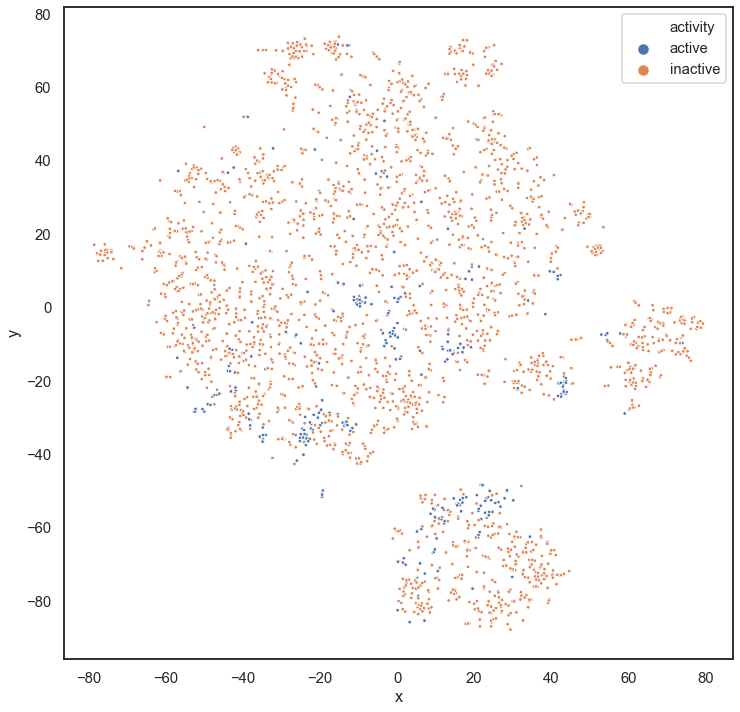

In [196]:
plt.figure(figsize=(12,12))
sns.scatterplot(data = tsne_df, x = 'x', y = 'y', hue='activity', s = 12)
plt.show()

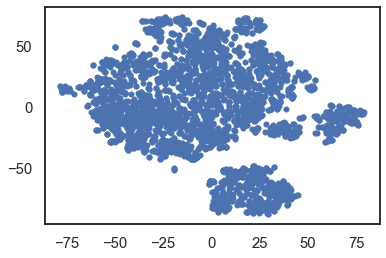

In [163]:
# Get the x and y values
x = tsne

plt.figure(figsize=(8,6))
plt.scatter(tsne.T[0], tsne.T[1], marker='.')

In [162]:
tsne

array([[-39.00125  ,  52.080936 ],
       [-39.1581   ,  17.396666 ],
       [-22.33207  , -32.99599  ],
       ...,
       [  1.4802973, -73.983864 ],
       [-56.75481  ,  -4.228641 ],
       [-29.725647 ,  59.440346 ]], dtype=float32)